In [1]:
import json
import gensim
import nltk
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Reviews.csv')

### Understanding the data

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568428 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


### Word cloud

In [5]:
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

stopwords = set(STOPWORDS)

mpl.rcParams['font.size']=12                 
mpl.rcParams['savefig.dpi']=100              
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

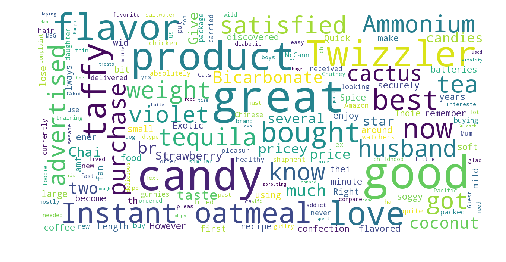

In [6]:
show_wordcloud(df[df['Score']>3].Text)

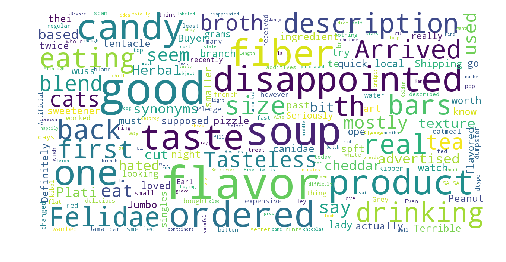

In [7]:
show_wordcloud(df[df['Score']<3].Text)

### Review rating in the dataset

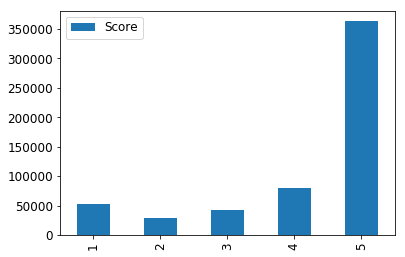

In [8]:
hist = pd.cut(df['Score'], 5, labels=[1,2,3,4,5]).value_counts(sort=False)
hist.to_frame().plot.bar()

### Word frequency across all reviews

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

word_vectorizer = CountVectorizer(analyzer='word', stop_words='english',min_df=2)
sparse_matrix = word_vectorizer.fit_transform(df['Text'])
frequencies = sum(sparse_matrix).toarray()[0]
words = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
print words.describe()
words.head(10)



           frequency
count   67923.000000
mean      312.873680
std      3989.618601
min         2.000000
25%         3.000000
50%         7.000000
75%        33.000000
max    647089.000000


,frequency
00,5108
000,783
0000,8
000001,2
00001,2
0001,3
0004,11
000kwh,14
000mg,11
000s,3


In [10]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

### Topic extraction with LDA

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 1000
n_components = 10
n_top_words = 25

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tfidf = vectorizer.fit_transform(df.Text)
feature_names = vectorizer.get_feature_names()

#print feature_names
lda = LatentDirichletAllocation(learning_method='online')
lda.fit(tfidf)
print("\nTopics in LDA model:")
print_top_words(lda, feature_names, n_top_words)


Topics in LDA model:
Topic #0: amazon price stores store grocery local delivery thanks fast shipping great product deal buying cheaper stale expensive love order condition locally good worth package pretzels
Topic #1: product order amazon great br buy box ordered price good time bought arrived gift received just purchase candy came got loved item purchased love shipping
Topic #2: com www http gp href amazon pack christmas product ounce shipment jelly packs peanuts expiration 12 date return 24 customer oz supply simple service br
Topic #3: br like taste good great just product flavor love sugar don really use water sweet little eat make ve snack better tastes try tried best
Topic #4: butter peanut jerky hair hazelnut mom toy china pumpkin ball moist crazy dried live freeze terrible absolutely quantity difficult careful turn hours loves dry worth
Topic #5: beef gum baby chai canned teeth formula stash difference tuna keeps vegan consistency microwave pie bone send gets daughter loves ea

### Checking the distribution of topics over reviews

In [12]:
topic_distrib = lda.transform(tfidf[0])
print df.iloc[0].Text, df.iloc[0].Score

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. 5


In [13]:
print topic_distrib
print "topics ordered:", np.argsort(topic_distrib[0])[::-1][:]

[[ 0.02176794  0.02176853  0.02176529  0.02177243  0.02176244  0.09035207
   0.02176503  0.73551623  0.02176354  0.02176652]]
topics ordered: [7 5 3 1 0 9 2 6 8 4]


In [14]:
topic_distrib = lda.transform(tfidf[11])
print df.iloc[11].Text, df.iloc[11].Score

One of my boys needed to lose some weight and the other didn't.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week. 5


In [15]:
print topic_distrib
print "topics ordered:", np.argsort(topic_distrib[0])[::-1][:]

[[ 0.02388318  0.02381082  0.06878562  0.02380331  0.02379758  0.02381686
   0.02378983  0.51050585  0.02379466  0.25401229]]
topics ordered: [7 9 2 0 5 1 3 4 8 6]
